### Basic Variables

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import netCDF4 as nc
import datetime as dt
import datetime
import configparser as cp
import os
import seaborn as sns
from PIL import Image
import warnings

In [3]:
# Preferences
plt.ioff()

# Universal Constants
test_folder = './testfolder/'
dataset = "../notebooks_test/templates/MUR_SST-Pre2020.nc"
annual_maxdhw = './annual_maxdhw/'
csv_folder = "./csv/"
graphs_folder = "./graphs/"

# Lists to be used
years = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']
years_2_incr = [('2010', '2011'), ('2011', '2012'), ('2012', '2013'), ('2013', '2014'), ('2014', '2015'), ('2015', '2016'), ('2016', '2017'), ('2017', '2018'), ('2018', '2019')]
years_3_incr = [('2010', '2011', '2012'), ('2011', '2012', '2013'), ('2012', '2013', '2014'), ('2013', '2014', '2015'), ('2014', '2015', '2016'), ('2015', '2016', '2017'), ('2016', '2017', '2018'), ('2017', '2018', '2019')]

# True or False for Specific Saves
save_df_max_and_avg_subparts = False
save_max_avg_graphs = True
save_max_avg_data = True
save_time_series_graphs = True
save_year_2_increment_graphs = True
save_year_3_increment_graphs = True
save_max_annual_diff = True

# Turn off warnings
warnings.filterwarnings("ignore")

### Loading in Required Files

In [4]:
# Load in netcdf4 file
f = nc.Dataset(dataset)
f

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): lat(35), lon(32), time(3653)
    variables(dimensions): float32 lat(lat), float32 lon(lon), int64 time(time), int16 analysed_sst(time, lat, lon)
    groups: 

In [5]:
# Create a blank dataframe
df = pd.DataFrame()

inter = f.variables['time'][:]

# Iterate through each time step
for i in range(1, len(inter) + 1):
    # 'i' is measure of days since 2002-06-01, utilize timedelta to convert to datetime
    date = dt.datetime(2002, 6, 1) + dt.timedelta(days=int(inter[i-1]))
    
    # Change to yyyymmdd format
    date = date.strftime('%Y%m%d')
    
    # If month is not '201010' for first 6 numbers, skip
    
    # For this particular array in the netcdf file, find the average of all values
    average = np.mean(f.variables['analysed_sst'][i - 1]) - 273.15
    
    # Add date, average to dataframe using concat
    df = pd.concat([df, pd.DataFrame({'date': [date], 'average': [average]})], ignore_index=True)
    
    # df

df

,date,average
0,20100101,27.697560
1,20100102,27.980149
2,20100103,28.007204
3,20100104,28.043740
4,20100105,27.776867
...,...,...
3648,20191228,27.739370
3649,20191229,27.619013
3650,20191230,27.464221
3651,20191231,27.350554


In [6]:
# Read the configuration file
config = cp.ConfigParser()
config.read('../config.ini')
print('Loaded in successfully')

Loaded in successfully


In [7]:
# Load in data for MUR SST pre 2020
path = config['settings']['MUR_pre2020'][1:]
path = f'..{path}'
path2 = '../data/refined/HRCS_nc/1985-2019_mmm_observed.nc'

# Load in mur data
mur = nc.Dataset(path)

# load in HRCS data
hrcs = nc.Dataset(path2)

print("Successful")

Successful


In [8]:
# Match the dimension of the two datasets, the latitude and longitude should be in the same range.
# Read the latitude and longitude values from the hrcs dataset
hrcs_lat = hrcs.variables['lat'][:]
hrcs_lon = hrcs.variables['lon'][:]

# Find the min and max of the latitude and longitude values
lat_min = hrcs_lat.min()
lat_max = hrcs_lat.max()
lon_min = hrcs_lon.min()
lon_max = hrcs_lon.max()

# Read the latitude and longitude values from the mur dataset
mur_lat = mur.variables['lat'][:]
mur_lon = mur.variables['lon'][:]

# Find the indices in the mur dataset that correspond to the hrcs ranges
lat_inds = np.where((mur_lat >= lat_min) & (mur_lat <= lat_max))[0]
lon_inds = np.where((mur_lon >= lon_min) & (mur_lon <= lon_max))[0]

# Use these indices to slice the mur dataset
mursst = mur.variables['analysed_sst'][:, lat_inds, lon_inds]

# Retrieve a list of the dates from the mur dataset
mursstdates = mur.variables['time'][:]

mur.close()

# Load hrcs to numpy array.
hrcs_sst = (hrcs.variables['variable'][:, :])
hrcs.close()

print("Successfully Changed Data")

Successfully Changed Data


In [9]:
print(f'Time: {mursst.shape[0]}, Lat: {mursst.shape[1]}, Lon: {mursst.shape[2]}')
print(hrcs_sst.shape)

Time: 3653, Lat: 30, Lon: 24
(30, 24)


In [10]:
# Load mur mmm nc file
path3 = '../data/refined/mur_mmm.nc'
mur_mmm = nc.Dataset(path3)

# Match the dimension of the two datasets, the latitude and longitude should be in the same range.
lat_inds = np.where((mur_mmm['lat'][:] >= lat_min) & (mur_mmm['lat'][:] <= lat_max))[0]
lon_inds = np.where((mur_mmm['lon'][:] >= lon_min) & (mur_mmm['lon'][:] <= lon_max))[0]
calculatedmmmsst = mur_mmm['mmm_sst'][:, lat_inds, lon_inds]

# Retrieve a list of labels for the time dimension
calculatedmmmssttime = mur_mmm['time'][:]

# Convert to list
calculatedmmmssttime = calculatedmmmssttime.tolist()

# Convert every item to an int
calculatedmmmssttime = [str(int(i)) for i in calculatedmmmssttime]

# Close
mur_mmm.close()

print(len(calculatedmmmssttime), type(calculatedmmmssttime))
print(calculatedmmmsst.shape, type(calculatedmmmsst))
print(calculatedmmmssttime)

156 <class 'list'>
(156, 30, 24) <class 'numpy.ma.core.MaskedArray'>
['202001', '202002', '202003', '202004', '202005', '202006', '202007', '202008', '202009', '202010', '202011', '202012', '202101', '202102', '202103', '202104', '202105', '202106', '202107', '202108', '202109', '202110', '202111', '202112', '202201', '202202', '202203', '202204', '202205', '202206', '202207', '202208', '202209', '202210', '202211', '202212', '201001', '201002', '201003', '201004', '201005', '201006', '201007', '201008', '201009', '201010', '201011', '201012', '201101', '201102', '201103', '201104', '201105', '201106', '201107', '201108', '201109', '201110', '201111', '201112', '201201', '201202', '201203', '201204', '201205', '201206', '201207', '201208', '201209', '201210', '201211', '201212', '201301', '201302', '201303', '201304', '201305', '201306', '201307', '201308', '201309', '201310', '201311', '201312', '201401', '201402', '201403', '201404', '201405', '201406', '201407', '201408', '201409', 

### Loading in the Average and Max DHWs

In [1]:
# Create a blank dataframe, with coluimns 'date' and 'dhw'
df_avg = pd.DataFrame(columns=['date', 'dhw'])
df_max = pd.DataFrame(columns=['date', 'dhw'])

# Load in data from 'folder' and cycle through all of them
for item in os.listdir(test_folder):
    date = item[:-4]
    
    # Load in csv file as a numpy array
    data = pd.read_csv(f'{test_folder}{item}')
    
    # Find the maximum value of the data
    maximum = data.max().max()
    
    # Find the average of the non nan values
    average = data.stack().mean()
    
    # Concatenate the date and average to the dataframe
    df_avg = pd.concat([df_avg, pd.DataFrame({'date': [date], 'dhw': [average]})], ignore_index=True)
    df_max = pd.concat([df_max, pd.DataFrame({'date': [date], 'dhw': [maximum]})], ignore_index=True)

# Sort the dataframe by date
df_avg = df_avg.sort_values('date')
df_max = df_max.sort_values('date')

# Save the dataframe as a csv file
if save_df_max_and_avg_subparts:
    df_avg.to_csv('./csvfiles/v2_avg.csv', index=False)
    df_max.to_csv('./csvfiles/v2_max.csv', index=False)

NameError: name 'pd' is not defined

2010 graph created
2011 graph created
2012 graph created
2013 graph created
2014 graph created
2015 graph created
2016 graph created
2017 graph created
2018 graph created
2019 graph created
2010 graph saved
2011 graph saved
2012 graph saved
2013 graph saved
2014 graph saved
2015 graph saved
2016 graph saved
2017 graph saved
2018 graph saved
2019 graph saved
Data saved
Complete


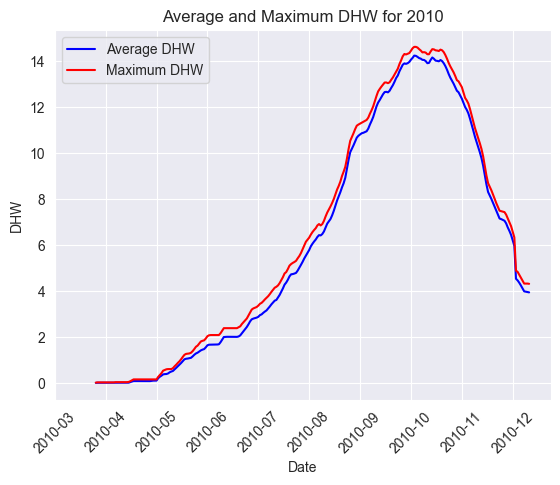

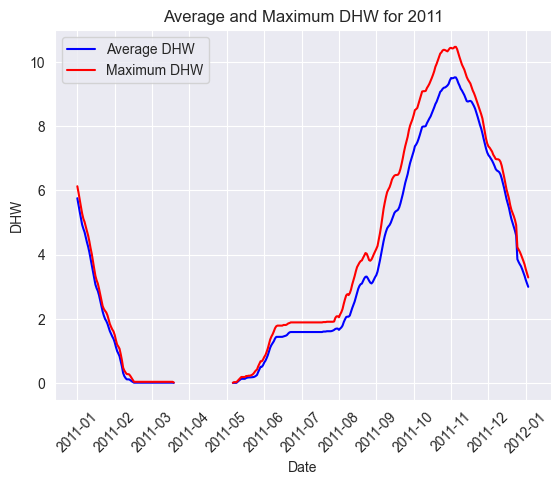

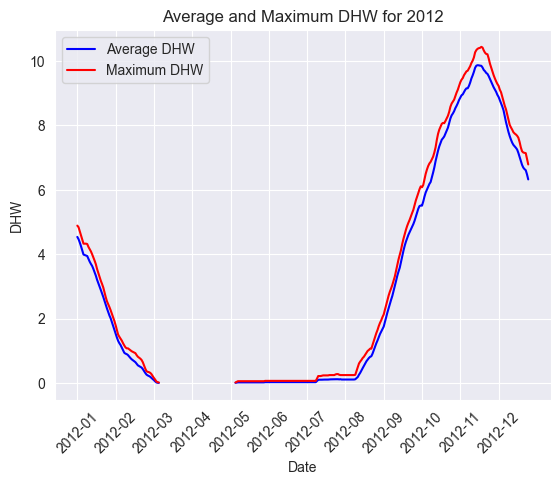

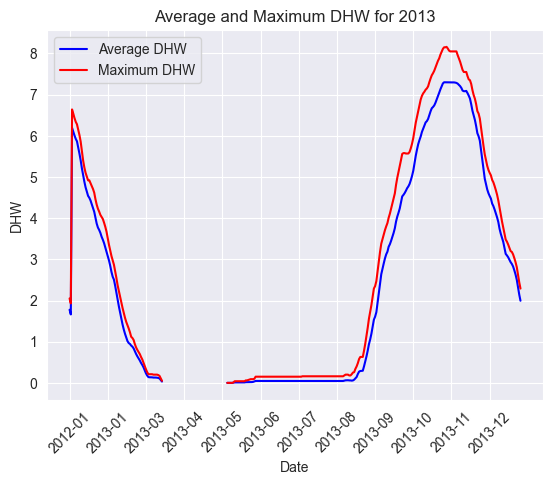

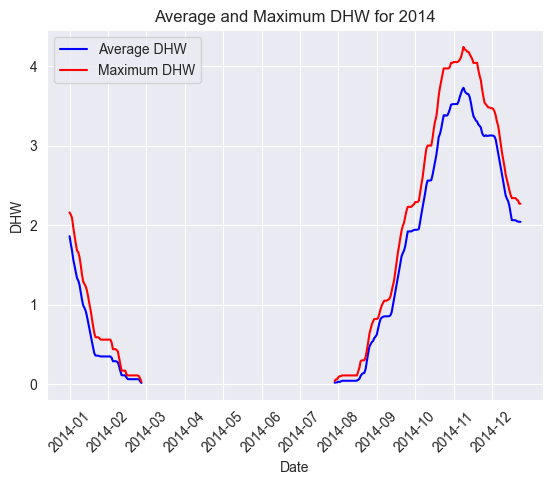

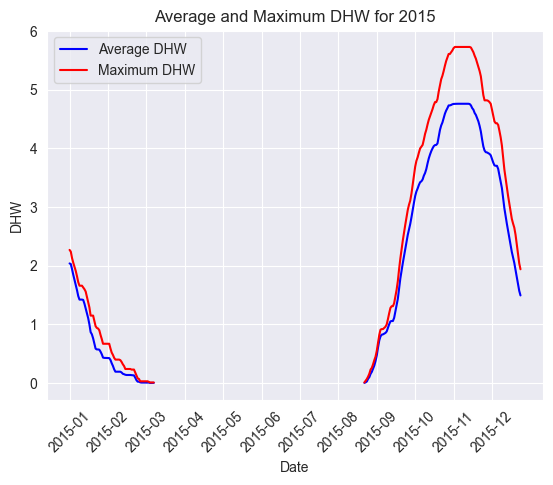

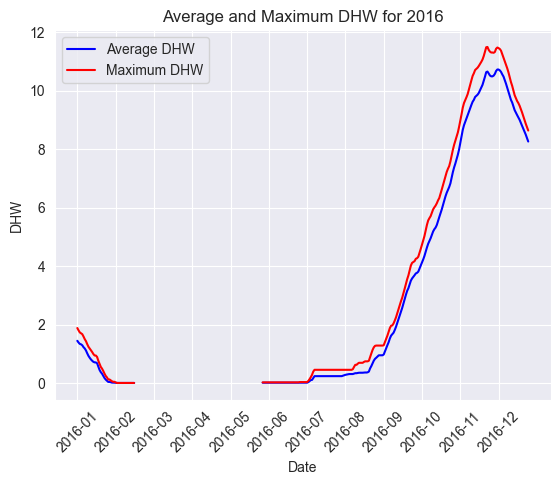

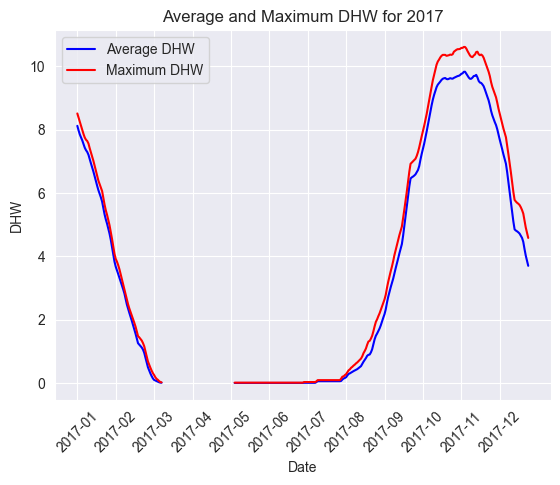

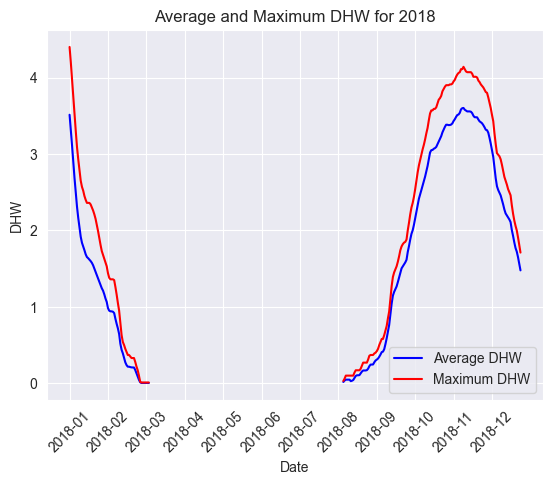

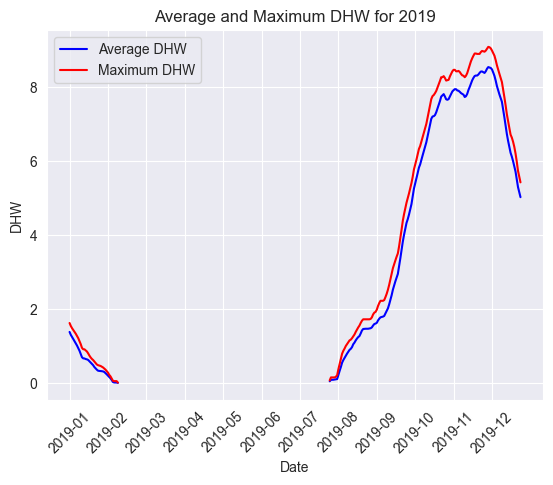

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [ ]:
# For years in the "year" list, create a matplotlib graph that shows the average and maximum DHW values for each year on a single graph.
# Append these graphs to a list called "max_avg_graphs"
max_avg_graphs = []
max_avg_data = pd.DataFrame(columns=["Date", "Max", "Average"]) # With columns 'date', 'max', 'avg'

for year in years:
    # Filter the dataframes to only include the data for the year
    df_avg_year = df_avg[df_avg['date'].str.contains(year)]
    df_max_year = df_max[df_max['date'].str.contains(year)]
    
    # Create a figure and axis, shape 2x5
    fig, ax = plt.subplots()
    
    # Add a graph style using seaborn
    sns.set_style('darkgrid')
    
    # Plot the average and maximum data on the axis
    ax.plot(df_avg_year['date'], df_avg_year['dhw'], label='Average DHW', color='blue')
    ax.plot(df_max_year['date'], df_max_year['dhw'], label='Maximum DHW', color='red')
    
    # Set the title and labels
    ax.set_title(f'Average and Maximum DHW for {year}')
    ax.set_xlabel('Date')
    ax.set_ylabel('DHW')
    
    # Make x-ticks monthly with a format of YYYY-MM
    plt.xticks(range(0, len(df_avg_year), 31), [f'{date[:4]}-{date[4:6]}' for date in df_avg_year['date'][::31]], rotation=45)
    
    # Rotate the x-axis labels
    plt.xticks(rotation=45)
    
    # Add a legend
    ax.legend()
    
    # Convert the fig to an image
    fig.canvas.draw()
    data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    # Append the graph to the list
    max_avg_graphs.append(data)
    
    # Add thee data to the dataframe
    max_avg_data = pd.concat([max_avg_data, pd.DataFrame({'Date': df_avg_year['date'], 'Max': df_max_year['dhw'], 'Average': df_avg_year['dhw']})], ignore_index=True)
    
    print(f'{year} graph created')

if save_max_avg_graphs:
    # Save the graphs as images
    for i, graph in enumerate(max_avg_graphs):
        # Make plot size slightly larger vertically
        plt.figure(figsize=(12, 6))
        img = Image.fromarray(graph)
        img.save(f'./Annual DHW/Max + Average Graphs/max_avg_dhw_{years[i]}.png')
        print(f'{years[i]} graph saved')

if save_max_avg_data:
    # Save the data as a csv file
    max_avg_data.to_csv(f'./Annual DHW/max_avg_dhw_data.csv', index=False)
    print('Data saved')

# Print Complete
print("Complete")

In [ ]:
max_graphs = []

for year in years:
    # Filter the dataframes to only include the data for the year
    df_max_year = df_max[df_max['date'].str.contains(year)]
    
    # Create a figure and axis, shape 2x5
    fig, ax = plt.subplots()
    
    # Add a graph style using seaborn
    sns.set_style('darkgrid')
    
    # Plot the average and maximum data on the axis
    ax.plot(df_max_year['date'], df_max_year['dhw'], label='Maximum DHW', color='red')
    
    # Set the title and labels
    ax.set_title(f'Average and Maximum DHW for {year}')
    ax.set_xlabel('Date')
    ax.set_ylabel('DHW')
    
    # Make x-ticks monthly with a format of YYYY-MM
    plt.xticks(range(0, len(df_max_year), 31), [f'{date[:4]}-{date[4:6]}' for date in df_max_year['date'][::31]], rotation=45)
    
    # Rotate the x-axis labels
    plt.xticks(rotation=45)
    
    # Add a legend
    ax.legend()
    
    # Convert the fig to an image
    fig.canvas.draw()
    data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    # Append the graph to the list
    max_graphs.append(data)
    
    print(f'{year} graph created')

# Save graphs to "./Annual DHW/Max Graphs/"
if save_max_avg_graphs:
    # Save the graphs as images
    for i, graph in enumerate(max_graphs):
        # Make plot size slightly larger vertically
        plt.figure(figsize=(12, 6))
        img = Image.fromarray(graph)
        img.save(f'./Annual DHW/Max Graphs/max_dhw_{years[i]}.png')
        print(f'{years[i]} graph saved')

# Print Complete
print("Complete")

2010 graph created
2011 graph created
2012 graph created
2013 graph created
2014 graph created
2015 graph created
2016 graph created
2017 graph created
2018 graph created
2019 graph created
2010 graph saved
2011 graph saved
2012 graph saved
2013 graph saved
2014 graph saved
2015 graph saved
2016 graph saved
2017 graph saved
2018 graph saved
2019 graph saved
Complete


### Time Series Per Cell

In [ ]:
# Cycle through all dates in "./testfolder", only listing the dates that start with 'year'
list_of_files = os.listdir(test_folder)

for year in years:
    # Filter the list of files to only include the files that start with 'year'
    yearly_files = [item for item in list_of_files if item.startswith(year)]

    # Create a blank array that stores all of the information, with the size of (length of year files, shape[0] of first item, shape[1] of first item)
    yearly_data = np.zeros((len(yearly_files), (pd.read_csv(f'{test_folder}{list_of_files[0]}')).shape[0], (pd.read_csv(f'{test_folder}{list_of_files[0]}')).shape[1]))

    # Iterate through all of the files in "yearly_files", adding them to the array, according to their index
    for i, item in enumerate(yearly_files):
        yearly_data[i] = pd.read_csv(f'{test_folder}{item}')
    
    # Replace any nan values with 0
    #yearly_data = np.nan_to_num(yearly_data, nan=0)
    #print(yearly_data.shape[0])
    
    df = pd.DataFrame(yearly_data.reshape(yearly_data.shape[0], -1))

    # Set the date range as the index of the DataFrame, date range should be monthly.
    date_range = pd.date_range(start=f'{year}-01-01', periods=yearly_data.shape[0], freq='D', name='Date')
    df.set_index(date_range, inplace=True)
    
    # Plot the time series for each cell in the 30x24 grid
    fig, ax = plt.subplots(figsize=(12, 8))
    for col in df.columns:
        ax.plot(df.index, df[col], linewidth=0.5)

    ax.set_xlabel('Date')
    ax.set_ylabel('DHW')
    ax.set_title(f'Time Series of DHW for {year}')
    
    plt.tight_layout()
    
    # Save the figure
    if save_time_series_graphs:
        plt.savefig(f'./Annual Time Series/{year}_time_series.png')

In [ ]:
# Reset the matplotlib graphs
plt.ion()

### Incremental Graphs

In [ ]:
# Check to see if './Annual DHW/max_avg_dhw_data.csv' exists, if it does, load it in
if os.path.exists('./Annual DHW/max_avg_dhw_data.csv'):
    df = pd.read_csv('./Annual DHW/max_avg_dhw_data.csv')
    print('Loaded in successfully')
else:
    print('File does not exist')
    # Create a blank dataframe, with coluimns 'date' and 'dhw'
    df_avg = pd.DataFrame(columns=['date', 'dhw'])
    df_max = pd.DataFrame(columns=['date', 'dhw'])

    # Load in data from 'folder' and cycle through all of them
    for item in os.listdir(test_folder):
        date = item[:-4]
        
        # Load in csv file as a numpy array
        data = pd.read_csv(f'{test_folder}{item}')
        
        # Find the maximum value of the data
        maximum = data.max().max()
        
        # Find the average of the non nan values
        average = data.stack().mean()
        
        # Concatenate the date and average to the dataframe
        df_avg = pd.concat([df_avg, pd.DataFrame({'date': [date], 'dhw': [average]})], ignore_index=True)
        df_max = pd.concat([df_max, pd.DataFrame({'date': [date], 'dhw': [maximum]})], ignore_index=True)

    # Sort the dataframe by date
    df_avg = df_avg.sort_values('date')
    df_max = df_max.sort_values('date')
    
    # Combine into a single dataframe labeled 'df'
    df = pd.merge(df_avg, df_max, on='date')

# Convert Dates column to strings
df['Date'] = df['Date'].astype(str)

df.head()

Loaded in successfully


,Date,Max,Average
0,20100326,NaN,NaN
1,20100327,NaN,NaN
2,20100328,NaN,NaN
3,20100329,NaN,NaN
4,20100330,NaN,NaN


In [ ]:
# Go through each list of years given in 'years_2_incr' and create a graph that shows the average and maximum DHW values for each year on a single graph.
for years in years_2_incr:
    # Filter df to find items that contain the matching years (column is "Date")
    df_years = df[df['Date'].str.contains(years[0]) | df['Date'].str.contains(years[1])]
    
    # Ensure they are in the correct order
    df_years = df_years.sort_values('Date')
    
    # Separate the Max and Average columns into their own lists.
    # max_values = df_years['Max'].tolist()
    # avg_values = df_years['Average'].tolist()
    
    # Plot the data
    fig, ax = plt.subplots()
    ax.plot(df_years['Date'], df_years['Max'], label='Max', color='red')
    ax.plot(df_years['Date'], df_years['Average'], label='Average', color='blue')
    
    # Set the title and labels
    ax.set_title(f'Average and Maximum DHW for {years[0]} and {years[1]}')
    ax.set_xlabel('Date')
    ax.set_ylabel('DHW')
    
    # Make x-ticks monthly with a format of YYYY-MM
    plt.xticks(range(0, len(df_years), 31), [f'{date[:4]}-{date[4:6]}' for date in df_years['Date'][::31]], rotation=45)
    
    # Rotate the x-axis labels
    plt.xticks(rotation=45)
    
    # Add a legend
    ax.legend()
    
    # Save the figure
    if save_year_2_increment_graphs:
        plt.savefig(f'./Year Increments/2 Year/{years[0]}_{years[1]}_dhw.png')

print("Completed 2 year increments")

In [ ]:
# Go through each list of years given in 'years_2_incr' and create a graph that shows the average and maximum DHW values for each year on a single graph.
for years in years_3_incr:
    # Filter df to find items that contain the matching years (column is "Date")
    df_years = df[df['Date'].str.contains(years[0]) | df['Date'].str.contains(years[1]) | df['Date'].str.contains(years[2])]
    
    # Ensure they are in the correct order
    df_years = df_years.sort_values('Date')
    
    # Separate the Max and Average columns into their own lists.
    # max_values = df_years['Max'].tolist()
    # avg_values = df_years['Average'].tolist()
    
    # Plot the data
    fig, ax = plt.subplots()
    ax.plot(df_years['Date'], df_years['Max'], label='Max', color='red')
    ax.plot(df_years['Date'], df_years['Average'], label='Average', color='blue')
    
    # Set the title and labels
    ax.set_title(f'Average and Maximum DHW for {years[0]}, {years[1]} and {years[2]}')
    ax.set_xlabel('Date')
    ax.set_ylabel('DHW')
    
    # Make x-ticks monthly with a format of YYYY-MM
    plt.xticks(range(0, len(df_years), 62), [f'{date[:4]}-{date[4:6]}' for date in df_years['Date'][::62]], rotation=45)
    
    # Rotate the x-axis labels
    plt.xticks(rotation=45)
    
    # Add a legend
    ax.legend()
    
    # Save the figure
    if save_year_3_increment_graphs:
        plt.savefig(f'./Year Increments/3 Year/{years[0]}-{years[2]}_dhw.png')

print("Completed 3 year increments")

Completed 3 year increments


### Annual Maximum DHW

2010 graph created
2011 graph created
2012 graph created
2013 graph created
2014 graph created
2015 graph created
2016 graph created
2017 graph created
2018 graph created
2019 graph created


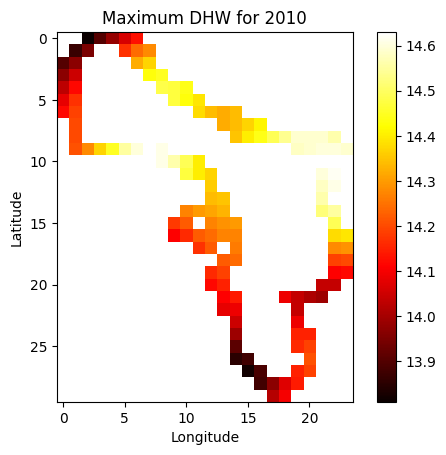

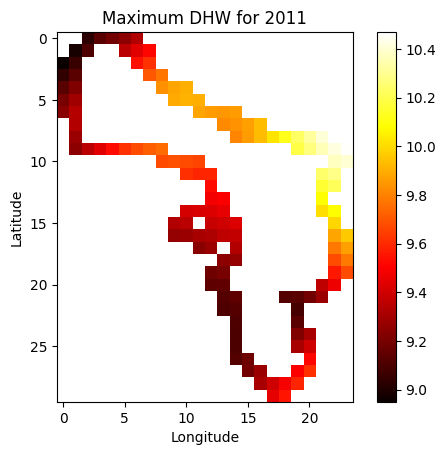

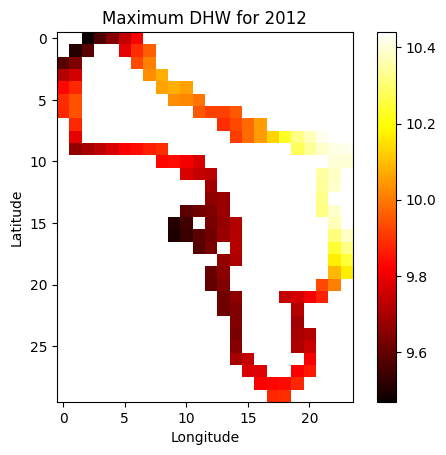

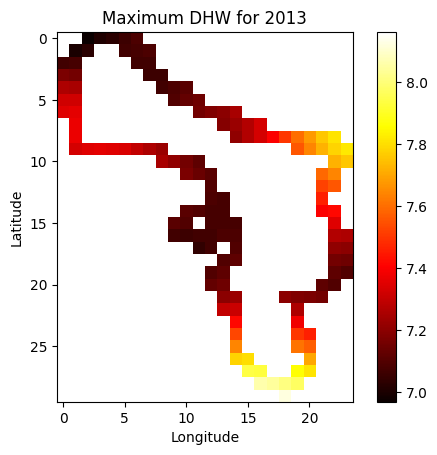

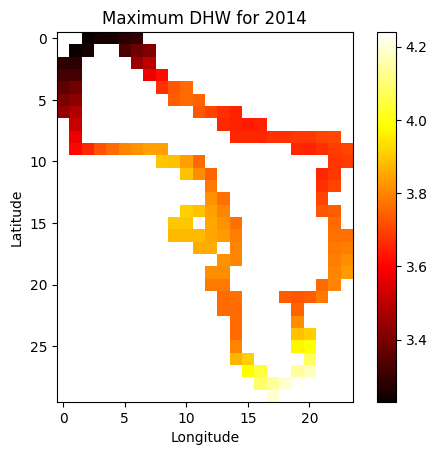

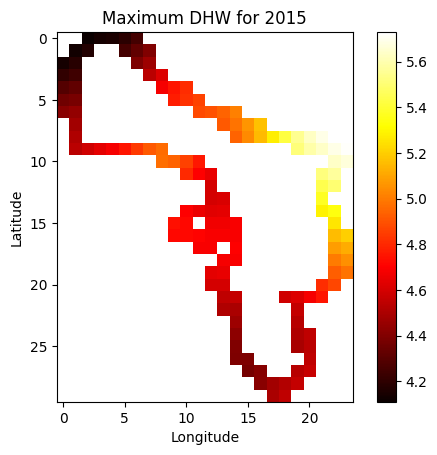

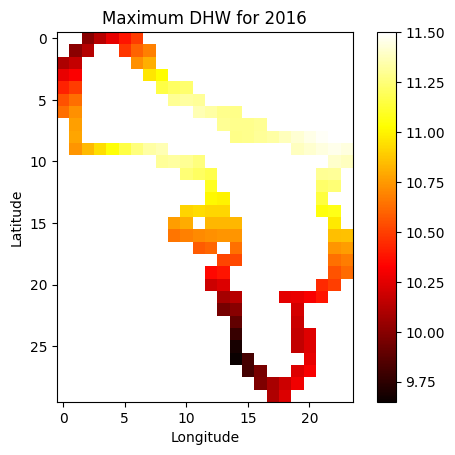

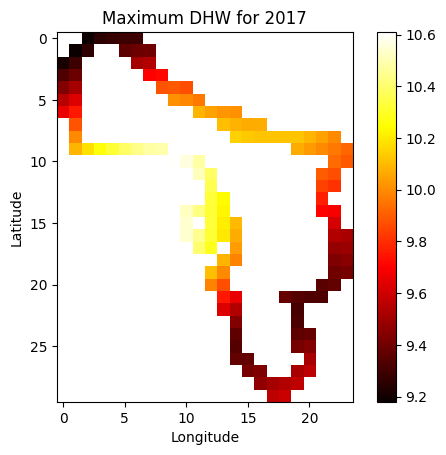

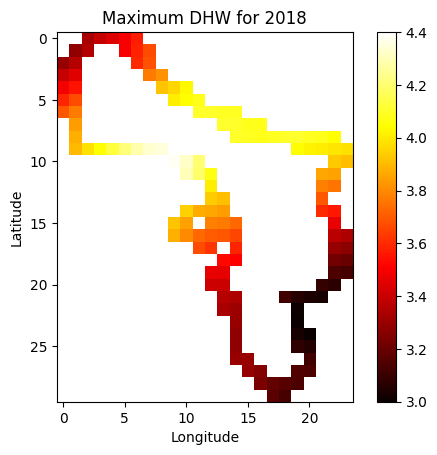

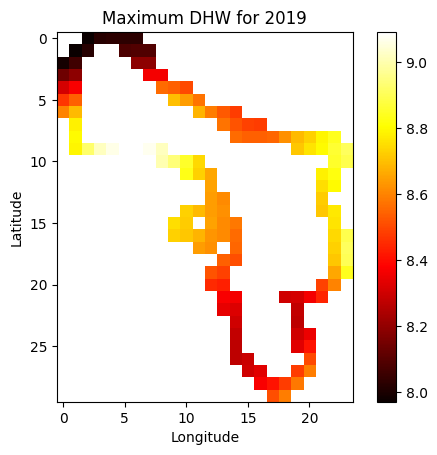

In [11]:
for year in years:
    # Cycle through files in testfolder, only list the files that start with 'year'
    yearly_files = [item for item in os.listdir(test_folder) if item.startswith(year)]
    
    # Load first item in list to get shape
    data = pd.read_csv(f'{test_folder}{yearly_files[0]}')
    
    # Create a 3d array with shape (len(yearly_files), shape[0] of first item, shape[1] of first item)
    yearly_data = np.zeros((len(yearly_files), data.shape[0], data.shape[1]))
    
    # Cycle through items in yearly_files, adding them to the array
    for i, item in enumerate(yearly_files): yearly_data[i] = pd.read_csv(f'{test_folder}{item}')
    
    # Replace nan values with 0
    yearly_data = np.nan_to_num(yearly_data, nan=0)
    
    # Find the maximum value in each index of y, z in the array
    max_values = np.max(yearly_data, axis=0)
    
    # replace the 0 values with np.nan
    max_values[max_values == 0] = np.nan
    
    # Create a figure and axis, with cmap of 'hot'
    fig, ax = plt.subplots()
    cax = ax.imshow(max_values, cmap='hot', interpolation='nearest')
    
    # Set the title and labels
    ax.set_title(f'Maximum DHW for {year}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
    # Add a colorbar
    fig.colorbar(cax)
    
    if save_annual_max_dhw:
        plt.savefig(f'./Annual Max DHW - Mapped/{year}_max_dhw.png')
    
    print(f'{year} graph created')

### Difference Between Max and Average

2010 graph created
2011 graph created
2012 graph created
2013 graph created
2014 graph created
2015 graph created
2016 graph created
2017 graph created
2018 graph created
2019 graph created


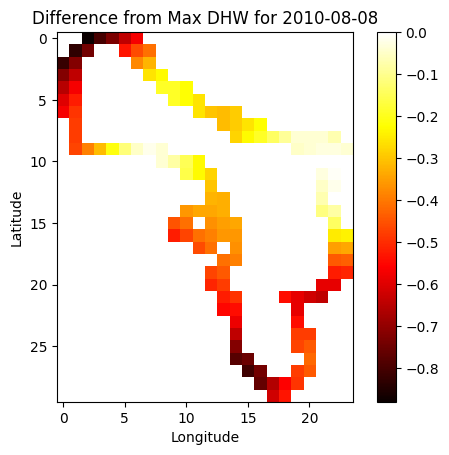

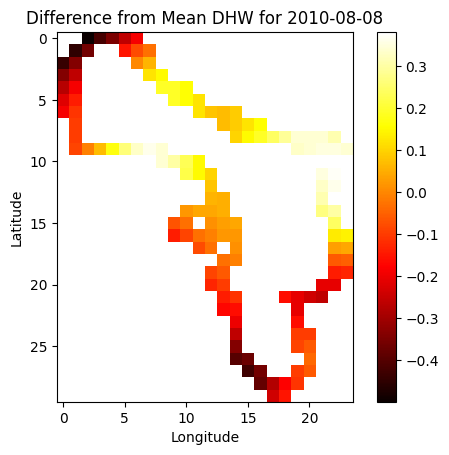

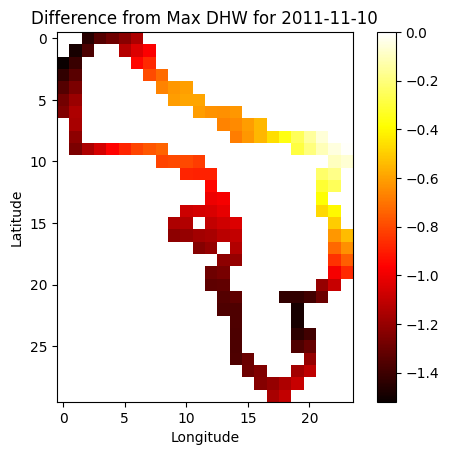

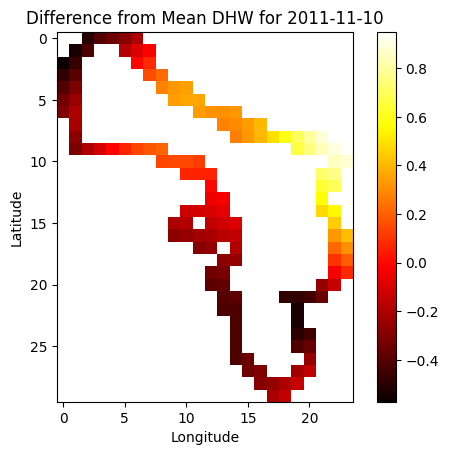

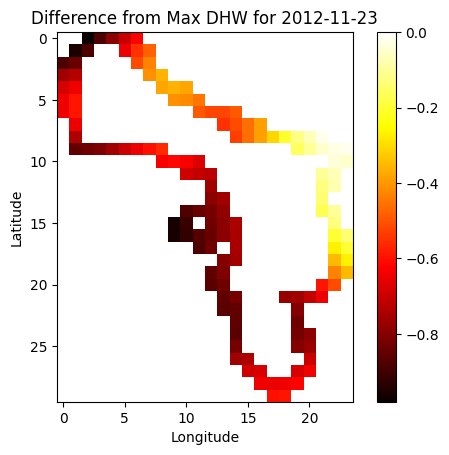

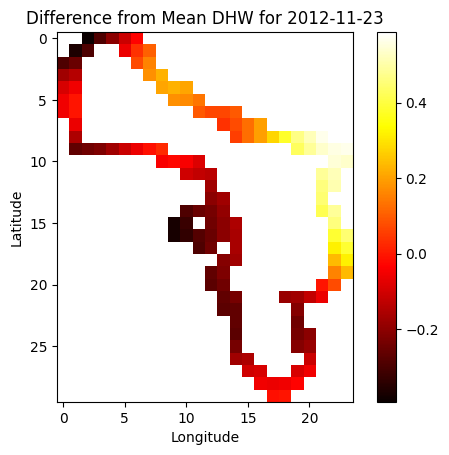

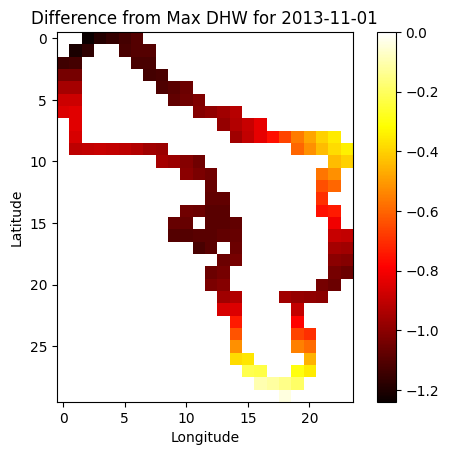

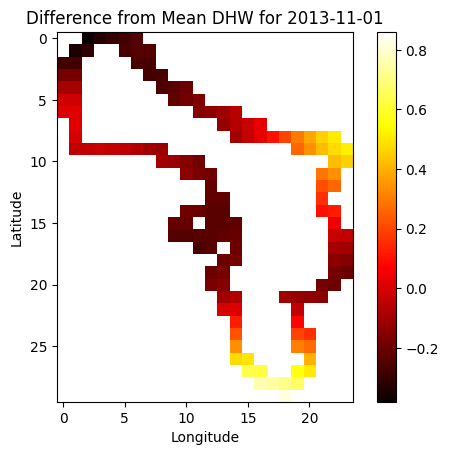

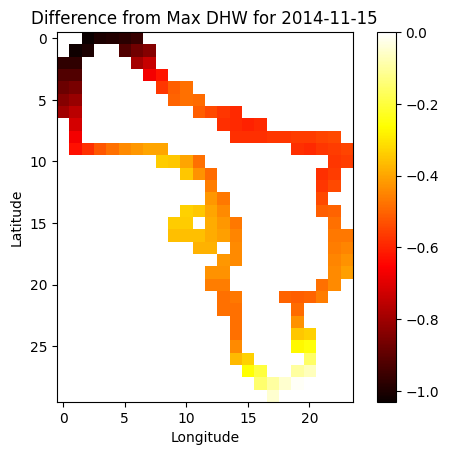

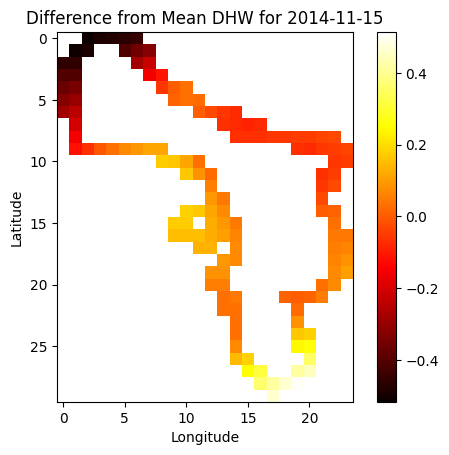

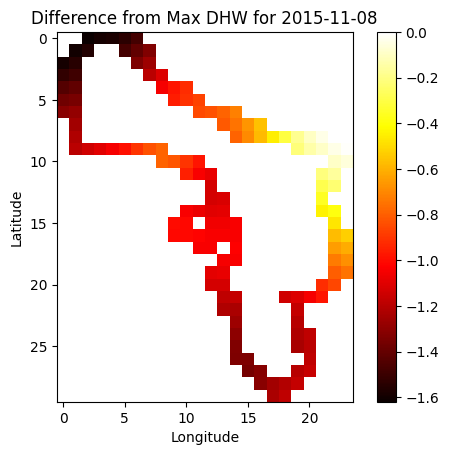

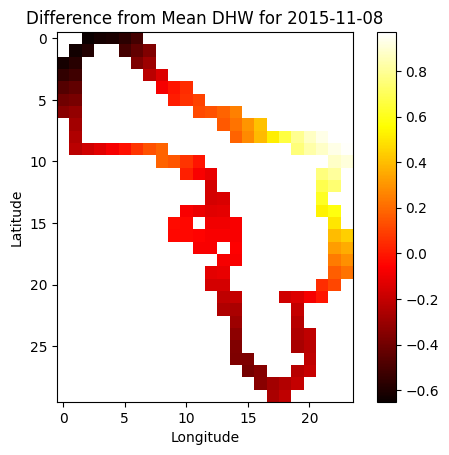

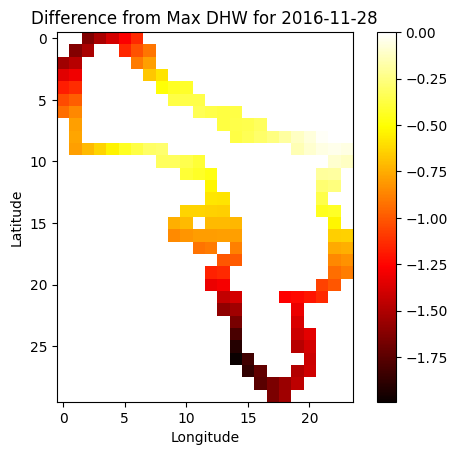

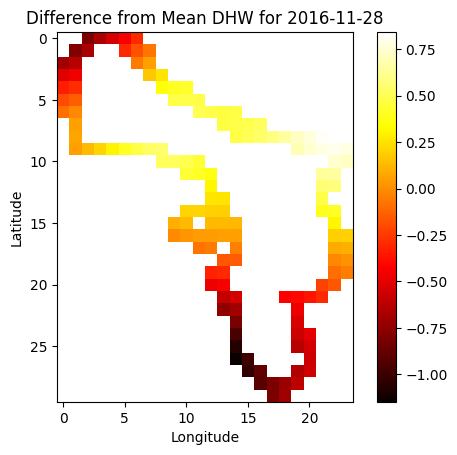

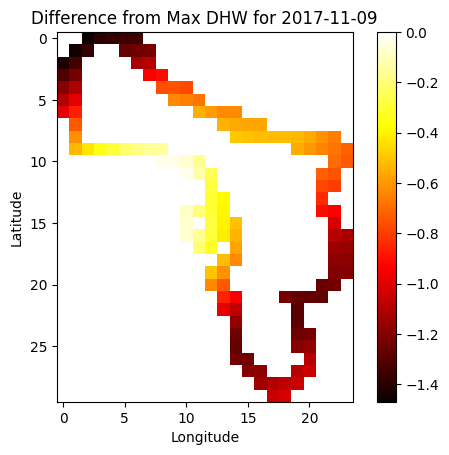

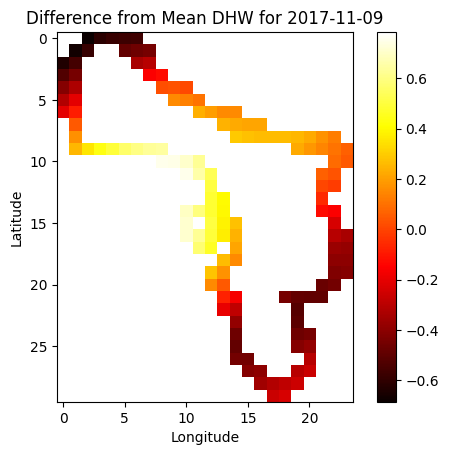

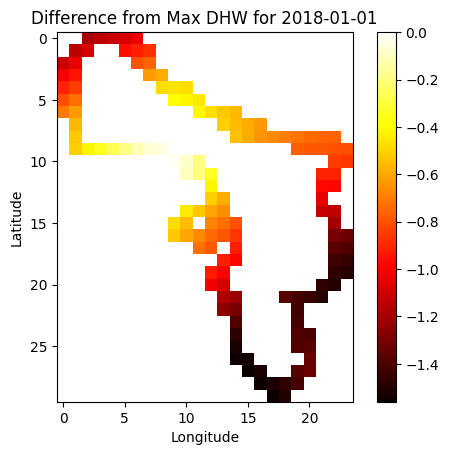

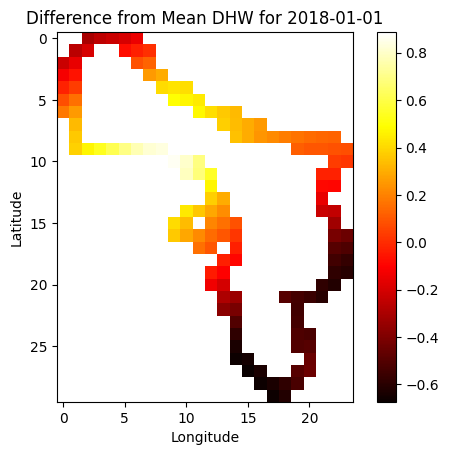

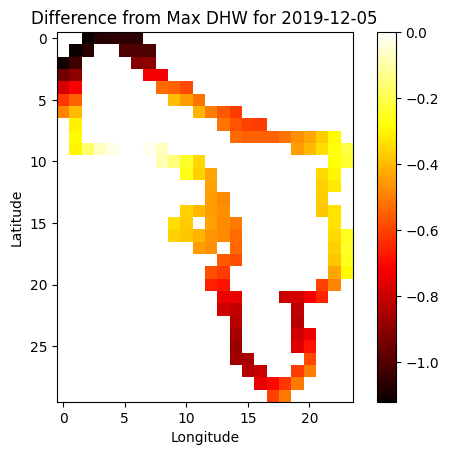

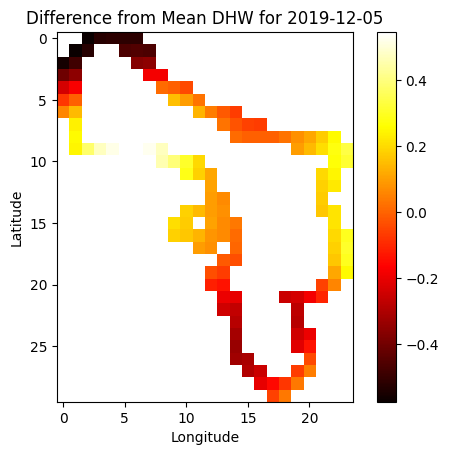

In [14]:
for year in years:
    # Cycle through files in testfolder, only list the files that start with 'year'
    yearly_files = [item for item in os.listdir(test_folder) if item.startswith(year)]
    
    # Load first item in list to get shape
    data = pd.read_csv(f'{test_folder}{yearly_files[0]}')
    
    # Create a 3d array with shape (len(yearly_files), shape[0] of first item, shape[1] of first item)
    yearly_data = np.zeros((len(yearly_files), data.shape[0], data.shape[1]))
    
    # Cycle through items in yearly_files, adding them to the array
    for i, item in enumerate(yearly_files): yearly_data[i] = pd.read_csv(f'{test_folder}{item}')
    
    # Replace nan values with 0
    yearly_data = np.nan_to_num(yearly_data, nan=0)
    
    # In the 3d array, find the date that contains the highest value in x,y,z
    # This should only be one value, not an array, list, etc.
    flat_index = np.argmax(yearly_data)
    index = np.unravel_index(flat_index, yearly_data.shape)
    
    # Load the values at the index location.
    lat = index[1]
    lon = index[2]
    value = yearly_data[index]
    
    # Based on value, use datetime to find the date, assuming it starts on January 1st.
    date = dt.datetime(int(year), 1, 1) + dt.timedelta(days=int(index[0]))
    
    # Make value date only no time.
    date = date.strftime('%Y-%m-%d')
    
    # Load this entire day, should be a 2d array found at index[0]
    day = yearly_data[index[0]]
    
    # Convert 0 values to nan
    day[day == 0] = np.nan
    
    # Subtract the value from the day.
    day_difference = day - value
    
    # Convert 
    
    # Create a figure and axis, with cmap of 'hot'
    fig, ax = plt.subplots()
    cax = ax.imshow(day_difference, cmap='hot', interpolation='nearest')
    
    # Set the title and labels
    ax.set_title(f'Difference from Max DHW for {date}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
    # Add a colorbar
    fig.colorbar(cax)
    
    if save_max_annual_diff:
        plt.savefig(f'./Difference Plots/Max/{date}_max_dhw_diff.png')
    
    # Now we have to do Mean
    # Find the mean of the day
    day = yearly_data[index[0]]
    day[day == 0] = np.nan
    day_mean = np.nanmean(day)
    #print(day_mean)
    
    # Subtract the mean from the day
    day_difference_mean = day - day_mean
    
    # Create a figure and axis, with cmap of 'hot'
    fig, ax = plt.subplots()
    cax = ax.imshow(day_difference_mean, cmap='hot', interpolation='nearest')
    
    # Set the title and labels
    ax.set_title(f'Difference from Mean DHW for {date}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
    # Add a colorbar
    fig.colorbar(cax)
    
    if save_max_annual_diff:
        plt.savefig(f'./Difference Plots/Mean/{date}_mean_dhw_diff.png')
    
    print(f'{year} graph created')